### Solve Burgers Eq. using WENO recontruction method

https://sci-hub.hkvisa.net/10.1006/jcph.1994.1187

We solve the Burgers eq.
$$
\partial_t u(x, t) + \partial_x f(u) = 0, \qquad f(u) = u^2 / 2 
$$
using WENOr2 and WENOr3 reconstruction methods to capture shocks in the u(x,t) field.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

%matplotlib widget

@njit
def f(u):
    return 0.5*u*u

@njit
def fp(u):
    return u

In [2]:
def TDV_RK(r, u_prev, xs, h, dt, n_ghost):
    if r == 2:
        return TDV_RK3(u_prev, xs, h, dt, n_ghost)
    elif r == 3:
        return TDV_RK4(u_prev, xs, h, dt, n_ghost)
    else:
        raise Exception("Order not implemented! r = 2 or 3")

def TDV_RK3(u_prev, xs, h, dt, n_ghost):
    """
    ## TO OPTIMIZE

    1**) Euler step t      --> t +   dt
    2**) Euler step t + dt --> t + 2*dt
    
    3**) Weighted mean btw t and t+2*dt to find t + dt/2
    
    4**) Euler step t + dt/2 -- > t + 3*dt/2
    
    5**) Weighted mean btw t and t+3*dt/2 to find  t + dt
    """
    rr = np.zeros_like(u_prev)
    
    # 1**)
    for j in range(1, len(rr)-2):
        rr[j] = L(2, j, u_prev, xs, h)
    u_n1 = u_prev + dt * rr
    u_n1 = PBC(u_n1, n_ghost)

    # 2**)
    for j in range(1, len(rr)-2):
        rr[j] = L(2, j, u_n1, xs, h)
    u_n2 = u_n1 + dt * rr
    u_n2 = PBC(u_n2, n_ghost)

    # 3**)
    u_n12 = 3 * u_prev / 4 + u_n2 / 4
    u_n12 = PBC(u_n12, n_ghost)

    # 4**)
    for j in range(1, len(rr)-2):
        rr[j] = L(2, j, u_n12, xs, h)
    u_n32 = u_n12 + dt * rr
    u_n32 = PBC(u_n32, n_ghost)

    # 5**)
    u_final = u_prev / 3 + 2 * u_n32 / 3
    return PBC(u_final, n_ghost)

def TDV_RK4(u_prev, xs, h, dt, n_ghost):
    """
    uj_0 = u_prev[j]
    uj_1 = uj_0 + dt * L(uj_0)
    uj_2 = uj_0 / 2 + u_j1 / 2 - dt * L(u_j1) / 4 + dt * L(u_j2) / 2
    u_j3 = uj_0 / 9 + 2 * u_j1 / 9 + 2 * u_j2 / 3 - dt * L(u_j1) / 9 - dt * L(u_j2) / 3 + dt * L(u_j3)
    u_new = u_j1 / 3 + u_j2 / 3 + u_j3 / 3 + dt * L(u_j2) / 6 + dt * L(u_j3) / 6
    """

    r_j1 = np.zeros_like(u_prev)
    r_j2 = np.zeros_like(u_prev)
    r_j3 = np.zeros_like(u_prev)

    for j in range(2, len(u_prev)-3):
        r_j1[j] = L(3, j, u_prev, xs, h)
    u_j1 = u_prev + dt*r_j1
    u_j1 = PBC(u_j1, n_ghost)

    for j in range(2, len(u_prev)-3):
        r_j2[j] = L(3, j, u_j1, xs, h)
    u_j2 = u_prev / 2 + u_j1 / 2 - dt*r_j1 / 4 + dt * r_j2 / 2
    u_j2 = PBC(u_j2, n_ghost)

    for j in range(2, len(u_prev)-3):
        r_j3[j] = L(3, j, u_j2, xs, h)
    u_j3 = u_prev/9 + 2*u_j1/9 + 2*u_j2/3 - dt*r_j1/9 - dt*r_j2/3 + dt*r_j3
    u_j3 = PBC(u_j3, n_ghost)
    
    out = u_j1/3 + u_j2/3 + u_j3/3 + dt*r_j2/6 + dt*r_j3/6
    return PBC(out, n_ghost)

In [3]:
def L(r, j, u, xs, h):
    """
    Equation 2.7b

    u  --> array of sol
    xs --> array of grid
    
    x_jm = x_{j - 1/2}
    x_jM = x_{j + 1/2}
    """
    x_jM = xs[j] + h / 2
    x_jm = xs[j] - h / 2
    
    o1 = flux( R(r, j  , x_jM, u, xs, h), R(r, j+1, x_jM, u, xs, h), u) 
    o2 = flux( R(r, j-1, x_jm, u, xs, h), R(r, j  , x_jm, u, xs, h), u)
    return - ( o1 - o2 ) / h

In [4]:
def R(r, j, x_pt, u, xs, h):
    if r == 2:
        return R2(j, x_pt, u, xs, h)
    elif r == 3:
        return R3(j, x_pt, u, xs, h)

def R2(j, x_pt, u, xs, h):
    """
    Equation 3.16
    """
    aj0 = alpha(2, j, 0, u)
    aj1 = alpha(2, j, 1, u)
    d = aj0 + aj1
    r1 = aj0 / d
    r2 = aj1 / d
    out = r1 * interpolants(2, j, x_pt, u, xs, h) + r2 * interpolants(2, j+1, x_pt, u, xs, h)
    return out

def R3(j, x_pt, u, xs, h):
    """
    Equation 3.18
    """
    aj0 = alpha(3, j, 0, u)
    aj1 = alpha(3, j, 1, u)
    aj2 = alpha(3, j, 2, u)
    d = aj0 + aj1 + aj2
    r1 = aj0 / d
    r2 = aj1 / d
    r3 = aj2 / d
    out = r1 * interpolants(3, j, x_pt, u, xs, h) + r2 * interpolants(3, j+1, x_pt, u, xs, h) + r3 * interpolants(3, j+2, x_pt, u, xs, h)
    return out

In [5]:
def alpha(r, j, i, u):
    if r == 2:
        return alpha_r2(j, i, u)
    elif r == 3:
        return alpha_r3(j, i, u)

@njit
def alpha_r2(j, i, u, eps = 1e-5):
    """
    Equations 3.17a & 3.17b 
    """
    if fp(u[j]) > 0:
        if i == 0:
            return 1 / 2 / (eps + SI(2, j, u))**2
        elif i == 1:
            return 1 / (eps + SI(2, j+1, u))**2
    elif fp(u[j]) <= 0:
        if i == 0:
            return 1 / (eps + SI(2, j, u))**2
        elif i == 1:
            return 1 / 2 / (eps + SI(2, j+1, u))**2

@njit
def alpha_r3(j, i, u, eps = 1e-5):
    """
    Equations 3.17a & 3.17b 
    """
    if fp(u[j]) > 0:
        if i == 0:
            return 1 / 12 / (eps + SI(3, j, u))**3
        elif i == 1:
            return 1 / 2 / (eps + SI(3, j+1, u))**3
        elif i == 2:
            return 1 / 4 / (eps + SI(3, j+2, u))**3
    elif fp(u[j]) <= 0:
        if i == 0:
            return 1 / 4 / (eps + SI(3, j, u))**3
        elif i == 1:
            return 1 / 2 / (eps + SI(3, j+1, u))**3
        elif i == 2:
            return 1 / 12 / (eps + SI(3, j+2, u))**3

In [6]:
def interpolants(r, j, x, u, xs, h):
    if r == 2:
        return interp_r2(j, x, u, xs, h)
    elif r == 3:
        return interp_r3(j, x, u, xs, h)

@njit
def interp_r2(j, x, u, xs, h):
    return u[j-1] + (u[j] - u[j-1]) * (x - xs[j-1]) / h

@njit
def interp_r3(j, x, u, xs, h):
    p1 = (u[j] - 2*u[j-1] + u[j-2]) * (x - xs[j-1])*(x - xs[j-1]) / 2 / h/h 
    p2 = (u[j] - u[j-2]) * (x - xs[j-1]) / 2 / h
    p3 = u[j-1] - (u[j] - 2*u[j-1] + u[j-2]) / 24

    return p1 + p2 + p3

In [7]:
@njit
def SI(r, j, u):
    if r == 2:
        return SI_r2(j, u)
    elif r == 3:
        return SI_r3(j, u)

@njit
def SI_r2(j, u):
    return (u[j] - u[j-1])**2

@njit
def SI_r3(j, u):
    p1 = (u[j-1] - u[j-2])**2
    p2 = (u[j] - u[j-1])**2
    p3 = (u[j] - 2*u[j-1] + u[j-2])**2

    return 0.5*(p1 + p2) + p3

In [8]:
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

def flux(a, b, u):
    """
    Godunov flux function
    Equation 2.5
    """
    u_dec = np.linspace(min(a,b), max(a,b))
    if a <= b:
        return min(f(u_dec))
        # u_cont = interp1d(u, f(u), bounds_error = False, fill_value = (f(u[0]), f(u[-1])))
        # return minimize_scalar(u_cont, bounds=(a, b), method='bounded').x
    elif a > b:
        return max(f(u_dec))
        # u_cont = interp1d(u, -f(u), bounds_error = False, fill_value = (-f(u[0]), -f(u[-1])))
        # return minimize_scalar(u_cont, bounds=(b, a), method='bounded').x

In [9]:
@njit
def PBC(arr, n_ghost):
    """
    # Left ghost equals last valid point
    arr[0] = arr[-2]
    # Right ghost equals first valid point
    arr[-1] = arr[1]
    """
    arr[:n_ghost] = arr[-2*n_ghost:-n_ghost]
    arr[-n_ghost:]= arr[n_ghost:2*n_ghost] 
    return arr

In [10]:
from tqdm.notebook import tqdm

r = 3

if r == 2:
    n_ghost = 1
elif r == 3:
    n_ghost = 2

h = 1e-2
nx = int(2 / h + 1 + 2*n_ghost)
# xs = np.linspace(-5, 5, nx)
xs = np.array([(i-n_ghost)*h - 1 for i in range(nx)])


u_prev = np.ones(len(xs)) # 1 + phys + 1
# Phys
# u_prev[xs > 0] = 0
# u_prev[(xs>-0.1) & (xs < 0.1)] = 1
# u_prev[n_ghost:-n_ghost] = np.exp(-200*xs[n_ghost:-n_ghost]**2)
u_prev[n_ghost:-n_ghost] = np.sin(4 * np.pi * xs[n_ghost:-n_ghost])
u_prev = PBC(u_prev, n_ghost)

# Ghosts
# u_prev = BC(u_prev)


N_it = 500


sol = np.zeros((len(u_prev[n_ghost:-n_ghost]), 3))
sol[:, 0] = u_prev[n_ghost:-n_ghost].copy()

t = 0
dt = 1e-3
for i in tqdm(range(N_it)):
    
    u_next = TDV_RK(r, u_prev, xs, h, dt, n_ghost)
    u_prev = u_next.copy()

    if t == 0.06:
       sol[:, 1] = u_next[n_ghost:-n_ghost].copy()
       t1 = t
    #    break
    t = t + dt
        
sol[:, 2] = u_next[n_ghost:-n_ghost].copy()

  0%|          | 0/500 [00:00<?, ?it/s]

(-1.0, 1.0)

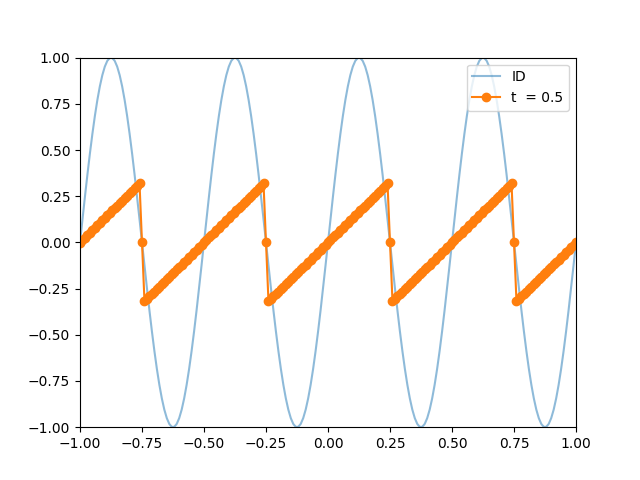

In [11]:
# ex = np.zeros_like(xs)
# ex[xs < 0.25] = 1

fig = plt.figure()

# plt.plot(xs, ex, 'k', label = 'Exact at t = 0.5')

plt.plot(xs[n_ghost:-n_ghost], sol[:, 0],       alpha = 0.5, label = 'ID')
# plt.plot(xs[n_ghost:-n_ghost], sol[:, 1],       alpha = 0.5, label = f'{t1 = }')
plt.plot(xs[n_ghost:-n_ghost], sol[:, 2], 'o-',              label = f't  = {np.round(t,2)}')

plt.legend()

# plt.axvline(0.5    , alpha = 0.5, color = 'k', ls = '--')
# plt.axvline(0.25   , alpha = 0.5, color = 'k', ls = '--')
# plt.axvline(0.125/2, alpha = 0.5, color = 'k', ls = '--')

plt.ylim((-1,1))
plt.xlim((-1, 1))